# Туториал по BERT Fine-Tuning с PyTorch

By Chris McCormick and Nick Ryan

*Revised on March 20, 2020 - Switched to `tokenizer.encode_plus` and added validation loss. See [Revision History](https://colab.research.google.com/drive/1pTuQhug6Dhl9XalKB0zUGf4FIdYFlpcX#scrollTo=IKzLS9ohzGVu) at the end for details.*




В этом учебнике я покажу вам, как использовать BERT с библиотекой PyTorch от huggingface для быстрой и эффективной донастройки модели и получения почти передовых результатов в классификации предложений. Более широко, я описываю практическое применение передачи обучения в области обработки естественного языка для создания высокопроизводительных моделей с минимальными усилиями для решения различных задач в NLP.

Этот пост представлен в двух формах--в виде блога [здесь](http://mccormickml.com/2019/07/22/BERT-fine-tuning/) и в виде тетрадки Colab [здесь](https://colab.research.google.com/drive/1pTuQhug6Dhl9XalKB0zUGf4FIdYFlpcX).

Содержание идентично в обоих случаях, но:
* В блоге есть раздел комментариев для обсуждения.
* Тетрадка Colab позволяет запускать код и изучать его по мере чтения.

Я также опубликовал видеообзор этого поста на своем YouTube канале! [Часть 1](https://youtu.be/x66kkDnbzi4) и [Часть 2](https://youtu.be/Hnvb9b7a_Ps).



# Содержание

Смотрите "Оглавление" в боковой панели слева.

# Введение


## История

2018 год был прорывным для обработки естественного языка (NLP). Transfer Learning, особенно модели, такие как ELMO от Allen AI, Open-GPT от OpenAI и BERT от Google, позволили исследователям побить несколько рекордов с минимальной донастройкой под конкретную задачу и предоставили остальному сообществу NLP предобученные модели, которые могли быть легко (с меньшим объемом данных и вычислительного времени) донастроены и применены для достижения передовых результатов. К сожалению, для многих новичков в области NLP, а также для некоторых опытных практиков, теория и практическое применение этих мощных моделей все еще недостаточно понятны.



## Что такое BERT?


BERT (Bidirectional Encoder Representations from Transformers), выпущенная в конце 2018 года, является моделью, которую мы будем использовать в этом учебнике, чтобы предоставить читателям лучшее понимание и практическое руководство по использованию моделей передачи обучения в области NLP. BERT - это метод предварительного обучения языковых представлений, который использовался для создания моделей, которые практики NLP могут бесплатно загрузить и использовать. Вы можете использовать эти модели для извлечения высококачественных языковых характеристик из ваших текстовых данных, или вы можете донастроить эти модели на конкретную задачу (классификация, распознавание сущностей, ответы на вопросы и т. д.) с использованием собственных данных для получения передовых прогнозов.

В этом посте будет объяснено, как вы можете модифицировать и донастроить BERT для создания мощной модели NLP, которая быстро дает вам передовые результаты..



## Преимущества Fine-Tuning


В этом учебнике мы будем использовать BERT для обучения классификатора текста. В частности, мы возьмем предварительно обученную модель BERT, добавим непрошедший обучение слой нейронов в конце и обучим новую модель для нашей задачи классификации. Почему мы делаем это, а не обучаем специфическую модель глубокого обучения (CNN, BiLSTM и т. д.), которая хорошо подходит для конкретной NLP-задачи, которую вам нужно решить?

1. **Более быстрая разработка**

    * Во-первых, предварительно обученные веса модели BERT уже содержат много информации о нашем языке. В результате, тренировка нашей донастроенной модели занимает гораздо меньше времени - это, как будто мы уже обширно обучили нижние слои нашей сети и нуждаемся только в их аккуратной настройке, используя их вывод как признаки для нашей задачи классификации. Фактически, авторы рекомендуют проводить всего 2-4 эпохи обучения для донастройки BERT на конкретной задаче NLP (в сравнении с сотнями часов работы GPU, необходимых для тренировки исходной модели BERT или LSTM с нуля!).

2. **Меньше данных**

    * Кроме того, и, возможно, так же важно, благодаря предварительно обученным весам этот метод позволяет нам донастраивать нашу задачу на гораздо меньшем наборе данных, чем требуется для модели, созданной с нуля. Основной недостаток моделей NLP, созданных с нуля, заключается в том, что нам часто требуется запретно большой набор данных для обучения сети с приемлемой точностью, что означает, что в создание набора данных приходится вложить много времени и энергии. Благодаря донастройке BERT мы теперь можем обучить модель с хорошей производительностью на гораздо меньшем объеме обучающих данных.

3. **Более хорошие результаты**

    * Наконец, показано, что этот простой процесс донастройки (обычно добавление одного полносвязного слоя поверх BERT и обучение на несколько эпох) достигает передовых результатов с минимальными настройками, специфичными для задачи, в широком спектре задач: классификация, логический вывод, семантическая схожесть, вопросно-ответная система и т. д. Вместо реализации специальных и иногда сложных архитектур, которые хорошо себя зарекомендовали в конкретной задаче, простая донастройка BERT показывает себя как лучшая (или, по крайней мере, равноценная) альтернатива.



### Сдвиг в области NLP

Этот переход к transfer learnining параллелен тому же сдвигу, который произошел в области компьютерного зрения несколько лет назад. Создание хорошей нейронной сети глубокого обучения для задач компьютерного зрения может потребовать миллионы параметров и быть очень дорогостоящим процессом обучения. Исследователи обнаружили, что глубокие сети изучают иерархические представления признаков (простые признаки, такие как края на самых нижних слоях, и постепенно более сложные признаки на более высоких слоях). Вместо обучения новой сети с нуля каждый раз, нижние слои обученной сети с обобщенными признаками изображений могут быть скопированы и использованы для передачи в другую сеть с другой задачей. Скоро это стало обычной практикой: скачивать предварительно обученную глубокую сеть и быстро дообучать ее для новой задачи или добавлять дополнительные слои сверху - что намного предпочтительнее дорогостоящего процесса обучения сети с нуля. Для многих введение предварительно обученных моделей глубокого обучения в области обработки естественного языка в 2018 году (ELMO, BERT, ULMFIT, Open-GPT и др.) сигнализирует о том же сдвиге к передаче обучения в NLP, который наблюдался в компьютерном зрении.

Давайте начнем!

# 1. Настройка

## 1.1. Использование GPU в Google Colab для обучения


Google Colab предлагает бесплатные графические процессоры (GPU) и процессоры Tensor Processing Unit (TPU)! Поскольку мы будем обучать большую нейронную сеть, лучше воспользоваться этим (в данном случае мы подключим GPU), иначе обучение займет очень много времени.

Чтобы добавить GPU, перейдите в меню и выберите:

`Edit 🡒 Notebook Settings 🡒 Hardware accelerator 🡒 (GPU)`

Затем выполните следующую ячейку, чтобы убедиться, что GPU обнаружен.

In [3]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()
print(device_name)

# The device name should look like the following:
# if device_name == '/device:GPU:0':
    # print('Found GPU at: {}'.format(device_name))
# else:
    # raise SystemError('GPU device not found')

Чтобы torch мог использовать GPU, нам нужно определить и указать GPU в качестве устройства. Позже, в нашем цикле обучения, мы будем загружать данные на устройство.

In [4]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 4090 Laptop GPU


## 1.2. Установка библиотеки Hugging Face


Далее установим пакет [transformers](https://github.com/huggingface/transformers) от Hugging Face, который предоставит нам интерфейс PyTorch для работы с BERT. (Эта библиотека содержит интерфейсы для других предварительно обученных языковых моделей, таких как GPT и GPT-2 от OpenAI.) Мы выбрали интерфейс PyTorch, потому что он обеспечивает хороший баланс между высокоуровневыми API (которые легко использовать, но не предоставляют понимания о том, как все работает) и кодом TensorFlow (который содержит много деталей, но часто отвлекает нас на уроки по TensorFlow, когда цель здесь - BERT!).

В настоящее время библиотека Hugging Face кажется наиболее широко принятой и мощной библиотекой PyTorch для работы с BERT. В дополнение к поддержке различных предварительно обученных моделей трансформера, в библиотеке также включены предварительно построенные модификации этих моделей, приспособленные к конкретной задаче. Например, в этом руководстве мы будем использовать `BertForSequenceClassification`.

В библиотеке также содержатся классы, специфические для задачи, такие как классификация токенов, ответ на вопрос, предсказание следующего предложения и т.д. Использование этих предварительно построенных классов упрощает процесс модификации BERT под ваши цели.


In [5]:
!pip install -q transformers

Код в этом блокноте на самом деле является упрощенной версией скрипта примера [run_glue.py](https://github.com/huggingface/transformers/blob/master/examples/run_glue.py) от Hugging Face.

`run_glue.py` - это полезная утилита, которая позволяет выбрать, на какой задаче GLUE вы хотите запуститься, и какую предварительно обученную модель вы хотите использовать (вы можете увидеть список возможных моделей [here](https://github.com/huggingface/transformers/blob/e6cff60b4cbc1158fbd6e4a1c3afda8dc224f566/examples/run_glue.py#L69)). Она также поддерживает использование либо процессора, либо одного графического процессора, либо нескольких графических процессоров. Она даже поддерживает использование 16-битной точности, если вы хотите ускорить процесс еще больше.

К сожалению, вся эта настраиваемость имеет свою цену в виде *читаемости*. В этом блокноте мы сильно упростили код и добавили множество комментариев, чтобы было понятно, что происходит.

# 2. Загрузка CoLA Dataset


Мы будем использовать набор данных [The Corpus of Linguistic Acceptability (CoLA)](https://nyu-mll.github.io/CoLA/) для классификации одиночных предложений. Это набор предложений, помеченных как грамматически правильные или неправильные. Он был впервые опубликован в мае 2018 года и является одним из тестов, включенных в "GLUE Benchmark", на котором модели, такие как BERT, соревнуются.


## 2.1. Загрузка и извлечение данных

Мы будем использовать пакет `wget` для загрузки набора данных в файловую систему экземпляра Colab.

In [6]:
!pip install wget

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9680 sha256=c4ff79a4ab729a21696246ce90f075a5d38634946a791dd7a3c4c8139e901da2
  Stored in directory: c:\users\руслан\appdata\local\pip\cache\wheels\40\b3\0f\a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


Набор данных размещен на GitHub в следующем репозитории: https://nyu-mll.github.io/CoLA/

In [7]:
import wget
import os

print('Downloading dataset...')

# The URL for the dataset zip file.
url = 'https://nyu-mll.github.io/CoLA/cola_public_1.1.zip'

# Download the file (if we haven't already)
if not os.path.exists('./cola_public_1.1.zip'):
    wget.download(url, './cola_public_1.1.zip')

100% [............................................................................] 255330 / 255330

Распакуйте набор данных в файловую систему. Вы можете просматривать файловую систему экземпляра Colab в боковой панели слева.

In [8]:
# Unzip the dataset (if we haven't already)
if not os.path.exists('./cola_public/'):
    !unzip cola_public_1.1.zip

Archive:  cola_public_1.1.zip
   creating: cola_public/
  inflating: cola_public/README      
   creating: cola_public/tokenized/
  inflating: cola_public/tokenized/in_domain_dev.tsv  
  inflating: cola_public/tokenized/in_domain_train.tsv  
  inflating: cola_public/tokenized/out_of_domain_dev.tsv  
   creating: cola_public/raw/
  inflating: cola_public/raw/in_domain_dev.tsv  
  inflating: cola_public/raw/in_domain_train.tsv  
  inflating: cola_public/raw/out_of_domain_dev.tsv  


## 2.2. Парсинг

Мы можем видеть по именам файлов, что доступны оба варианта данных: `tokenized` и `raw`.

Мы не можем использовать предварительно токенизированную версию, потому что для применения предварительно обученной модели BERT необходимо использовать токенизатор, предоставленный моделью. Это связано с тем, что (1) у модели есть определенный, фиксированный словарь и (2) токенизатор BERT имеет свой специфический способ обработки слов, не входящих в словарь.

Мы будем использовать библиотеку pandas для разбора набора данных "in-domain" тренировочного набора и рассмотрим некоторые его свойства и данные.

In [9]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df = pd.read_csv("./cola_public/raw/in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

# Display 10 random rows from the data.
df.sample(10)

Number of training sentences: 8,551



,sentence_source,label,label_notes,sentence
7423,sks13,0,*,"Yes, she."
3277,l-93,0,*,In price soared oil.
8005,ad03,1,NaN,That Jason arrived infuriated Medea.
3711,ks08,1,NaN,I consider John the best candidate.
5841,c_13,1,NaN,I think that he eats asparagus.
8299,ad03,0,*,Jason whispered the phoenix had escaped
5761,c_13,1,NaN,I didn't read a single book the whole time I w...
1173,r-67,1,NaN,I know a man who John is as tall as.
388,bc01,1,NaN,Could they have left?
7025,sgww85,1,NaN,Kim alienates cats and beats his dog.


Два свойства, которые нам на самом деле интересны, это `sentence` (предложение) и его `label` (метка), которая называется "acceptibility judgment" (0=неприемлемо, 1=приемлемо).

Вот пять предложений, которые помечены как грамматически неприемлемые. Обратите внимание, насколько сложной является эта задача по сравнению, например, с анализом тональности!

In [10]:
df.loc[df.label == 0].sample(5)[['sentence', 'label']]

,sentence,label
5661,I ate apple.,0
5095,Wear it like that is what you do.,0
2538,I put the book from Edna.,0
8263,Gilgamesh might can seek Ishtar,0
7931,The Greeks arrived all.,0





Давайте извлечем предложения и метки нашего тренировочного набора данных в виде массивов numpy.

In [11]:
# Get the lists of sentences and their labels.
sentences = df.sentence.values
labels = df.label.values

# 3. Токенизация и форматирование входных данных

В этом разделе мы преобразуем наш набор данных в формат, на котором можно обучать BERT.

## 3.1. BERT Tokenizer

Для передачи нашего текста в BERT его необходимо разделить на токены, а затем эти токены должны быть сопоставлены со своим индексом в словаре токенизатора.

Токенизацию необходимо выполнить с помощью токенизатора, включенного в BERT -- в следующей ячейке будет выполнено его скачивание. Здесь мы будем использовать версию "uncased" (без учета регистра).


In [12]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

C:\Users\Руслан\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:1138: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Давайте применим токенизатор к одному предложению, чтобы увидеть результат.


In [13]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  Our friends won't buy this analysis, let alone the next one we propose.
Tokenized:  ['our', 'friends', 'won', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.']
Token IDs:  [2256, 2814, 2180, 1005, 1056, 4965, 2023, 4106, 1010, 2292, 2894, 1996, 2279, 2028, 2057, 16599, 1012]


Когда мы фактически преобразуем все наши предложения, мы будем использовать функцию `tokenize.encode`, чтобы выполнить оба шага одновременно, вместо того, чтобы вызывать `tokenize` и `convert_tokens_to_ids` отдельно.

Однако, перед тем как мы сможем это сделать, нам нужно рассмотреть некоторые требования форматирования BERT.

## 3.2. Необходимое форматирование

Вышеуказанный код пропустил несколько требуемых этапов форматирования, которые мы рассмотрим здесь.

*Примечание: Формат входных данных для BERT кажется "чрезмерно подробным"... Нам требуется предоставить ему несколько элементов информации, которые кажутся избыточными или могут быть легко выведены из данных без явного предоставления. Но это то, что есть, и я полагаю, что это станет более понятным, когда я более глубоко пойму внутреннее устройство BERT.

Мы обязаны:
1. Добавить специальные токены в начало и конец каждого предложения.
2. Дополнить и обрезать все предложения до фиксированной длины.
3. Явно разграничить реальные токены от токенов-заполнителей с помощью "маски внимания" (attention mask).



### Особые Токены



**`[SEP]`**

В конце каждого предложения нам нужно добавить специальный токен `[SEP]`.

Этот токен является артефактом задач, в которых BERT получает два отдельных предложения и запрашивается определенная информация (например, можно ли найти ответ на вопрос в предложении A в предложении B?).

Пока я не уверен, почему этот токен все равно требуется, когда у нас есть только одно предложение, но так оно работает!


**`[CLS]`**

Для задач классификации мы должны добавить специальный токен `[CLS]` в начало каждого предложения.

Этот токен имеет особое значение. BERT состоит из 12 слоев трансформера. Каждый трансформер принимает список векторных представлений токенов и выдает то же самое количество представлений на выходе (но, конечно, со измененными значениями признаков!).

![Illustration of CLS token purpose](./lustration_of_CLS_token_purpose.png)


На выходе последнего (12-го) трансформера используется *только первый эмбеддинг (соответствующий токену [CLS]) классификатором*.

>  "Первый токен каждой последовательности всегда является специальным токеном классификации ([CLS]). Последнее скрытое состояние, соответствующее этому токену, используется в качестве агрегированного представления последовательности для задач классификации." (из [BERT paper](https://arxiv.org/pdf/1810.04805.pdf))

Можно подумать о применении стратегии пулинга к финальным эмбедингам, но это необязательно. Поскольку BERT обучается использовать только этот токен [CLS] для классификации, мы знаем, что модель была мотивирована кодировать все необходимое для шага классификации в этот одиночный вектор эмбединга размером 768 значений. Она уже сделала для нас пулинг!



### Длина предложений и Attention Mask



Предложения в нашем наборе данных, очевидно, имеют различную длину, так что как BERT справляется с этим?

У BERT есть два ограничения:
1. Все предложения должны быть заполнены или обрезаны до одной фиксированной длины.
2. Максимальная длина предложения - 512 токенов.

Заполнение выполняется с помощью специального токена `[PAD]`, который находится на индексе 0 в словаре BERT. Ниже приведена иллюстрация заполнения до "MAX_LEN" из 8 токенов.

<img src="./lustration_of_CLS_token_purpose1.png" width="600">

Маска внимания (Attention Mask) представляет собой просто массив из 1 и 0, указывающий, какие токены являются заполнением, а какие нет (похоже, что это излишне, не так ли?!). Эта маска сообщает механизму "Self-Attention" в BERT не учитывать эти токены PAD в интерпретации предложения.

Максимальная длина действительно влияет на скорость обучения и оценки. Например, с использованием Tesla K80:

`MAX_LEN = 128  -->  Training epochs take ~5:28 each`

`MAX_LEN = 64   -->  Training epochs take ~2:57 each`








[![BERT eBook Display Ad](./BERT_eBook_Display_Ad.png)](https://www.chrismccormick.ai/bert-ebook?utm_source=colab&utm_medium=banner&utm_campaign=bert_ebook&utm_content=colab0)


## 3.3. Токенизация набора данных

Библиотека transformers предоставляет полезную функцию `encode`, которая будет обрабатывать большинство шагов парсинга и подготовки данных за нас.

Однако, прежде чем мы будем готовы токенизировать наш текст, нам нужно определить максимальную длину предложения, до которой будем заполнять или обрезать предложения.

Нижеприведенная ячейка выполнит один проход токенизации набора данных, чтобы измерить максимальную длину предложения.

In [14]:
max_len = 0

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  47



На всякий случай, если в текстовых предложениях есть более длинные предложения, я установлю максимальную длину в 64 токена.


Теперь мы готовы выполнить фактическую токенизацию.

Функция `tokenizer.encode_plus` выполняет несколько шагов:

1. Разделяет предложение на токены.
2. Добавляет специальные токены `[CLS]` и `[SEP]`.
3. Сопоставляет токены с их идентификаторами.
4. Дополняет или усекает все предложения до одинаковой длины.
5. Создает маску внимания, которая явно различает реальные токены от `[PAD]` токенов.



Первые четыре признака находятся в `tokenizer.encode`, но я использую `tokenizer.encode_plus`, чтобы получить пятый атрибут - маски внимания (attention masks). Документацию можно найти [здесь](https://huggingface.co/transformers/main_classes/tokenizer.html?highlight=encode_plus#transformers.PreTrainedTokenizer.encode_plus).


In [15]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\Руслан\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  Our friends won't buy this analysis, let alone the next one we propose.
Token IDs: tensor([  101,  2256,  2814,  2180,  1005,  1056,  4965,  2023,  4106,  1010,
         2292,  2894,  1996,  2279,  2028,  2057, 16599,  1012,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


## 3.4. Разделение на обучающую и валидационную выборки (Training & Validation Split)


Разделим нашу обучающую выборку на обучающую и валидационную выборки, чтобы использовать 90% данных для обучения модели и 10% для валидации.

In [16]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

7,695 training samples
  856 validation samples


Мы также создадим итератор для нашего датасета, используя класс DataLoader из библиотеки torch. Это поможет сэкономить память во время обучения, потому что, в отличие от цикла for, с итератором не требуется загружать весь датасет в память.

In [17]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it
# here. For fine-tuning BERT on a specific task, the authors recommend a batch
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# 4. Тренируем нашу модель для классификации

Теперь, когда наши входные данные правильно отформатированы, пришло время дообучать модель BERT.

## 4.1. BertForSequenceClassification

Для этой задачи мы сначала хотим модифицировать предобученную модель BERT, чтобы она выдавала выходные данные для классификации, а затем продолжить обучение модели на нашем наборе данных, пока вся модель, от начала до конца, не будет хорошо подходить для нашей задачи.

К счастью, реализация huggingface на основе pytorch включает набор интерфейсов, разработанных для различных задач NLP. Хотя все эти интерфейсы построены на основе обученной модели BERT, у каждого из них есть разные верхние слои и типы выходных данных, предназначенные для выполнения конкретной задачи NLP.

Вот текущий список предоставляемых классов для дообучения:
* BertModel
* BertForPreTraining
* BertForMaskedLM
* BertForNextSentencePrediction
* **BertForSequenceClassification** - The one we'll use.
* BertForTokenClassification
* BertForQuestionAnswering

Документацию для этих классов можно найти по ссылке [здесь](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html).



Мы будем использовать [BertForSequenceClassification](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#bertforsequenceclassification). Это обычная модель BERT с добавленным одним линейным слоем сверху для классификации, которую мы будем использовать в качестве классификатора предложений. При подаче входных данных вся предобученная модель BERT и дополнительный натренированный слой классификации обучаются на нашей конкретной задаче.


Хорошо, давайте загрузим BERT! Доступны несколько предобученных моделей BERT. "bert-base-uncased" означает версию, в которой только строчные буквы ("uncased") и это более маленькая версия из двух ("base" по сравнению с "large").

Документацию для `from_pretrained` можно найти [здесь](https://huggingface.co/transformers/v2.2.0/main_classes/model.html#transformers.PreTrainedModel.from_pretrained), с дополнительно определенными параметрами [здесь](https://huggingface.co/transformers/v2.2.0/main_classes/configuration.html#transformers.PretrainedConfig).

In [18]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single
# linear classification layer on top.
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e


Только из любопытства мы можем просмотреть все параметры модели по их именам здесь.

В следующей ячейке я вывел имена и размерности весов для:

1. Слой эмбеддингов (embedding).
2. Первый из двенадцати трансформеров.
3. Выходной слой (output layer).




In [19]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

## 4.2. Оптимизатор и планировщик скорости обучения

Теперь, когда мы загрузили модель, нам нужно получить гиперпараметры обучения из сохраненной модели.

В целях дообучения авторы рекомендуют выбирать значения из следующего набора параметров: (из Appendix A.3 из [BERT paper](https://arxiv.org/pdf/1810.04805.pdf)):

>- **Batch size:** 16, 32  
- **Learning rate (Adam):** 5e-5, 3e-5, 2e-5  
- **Number of epochs:** 2, 3, 4

Мы вибираем:
* Batch size: 32 (устанавливается, когда создаётся DataLoaders)
* Learning rate: 2e-5
* Epochs: 4 (мы увидим, что это, вероятно, слишком много...)

Параметр epsilon `eps = 1e-8` является "очень малым числом, чтобы избежать деления на ноль при выполнении" ([отсюда](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)).

Вы можете найти создание AdamW optimizer в `run_glue.py` [here](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L109).

In [20]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


C:\Users\Руслан\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [21]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4.
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

## 4.3. Тренировочный цикл

Ниже представлен наш цикл обучения. Здесь происходит много действий, но в основе каждой итерации у нас есть фаза обучения и фаза валидации.

> *Благодарим Стаса Бекмана [Stas Bekman](https://ca.linkedin.com/in/stasbekman) за вклад в предоставление идей и кода для использования потери (loss) на валидации в качестве индикатора over-fitting!*

**Тренировка:**
- Распаковка входных данных и меток
- Загрузка данных на GPU для ускорения вычислений
- Очистка ранее вычисленных градиентов
    -  В PyTorch градиенты аккумулируются по умолчанию (это полезно, например, для RNN), если их явно не очистить.
-  Прямой проход (подача входных данных через сеть)
- Обратный проход (обратное распространение ошибки)
- Обновление параметров сети с помощью optimizer.step()
- Отслеживание переменных для контроля прогресса

**Валидация:**
- Распаковка входных данных и меток
- Загрузка данных на GPU для ускорения вычислений
- Прямой проход (подача входных данных через сеть)
- Вычисление потерь на валидационных данных и отслеживание переменных для контроля прогресса

PyTorch скрывает от нас все детали вычислений, но мы прокомментировали код, чтобы указать, какие из вышеуказанных шагов выполняются на каждой строке.

> *PyTorch имеет также несколько [туториолов для начинающих](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) которые могут оказаться полезными для вас.*

Вспомогательная функция для вычисления точности (accuracy) на основе предсказанных и истинных меток:



In [22]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

Helper function for formatting elapsed times as `hh:mm:ss`


In [23]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


We're ready to kick off the training!

In [24]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss,
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because
        # accumulating the gradients is "convenient while training RNNs".
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward`
        # function and pass down the arguments. The `forward` function is
        # documented here:
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        result = model(b_input_ids,
                       token_type_ids=None,
                       attention_mask=b_input_mask,
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model(b_input_ids,
                           token_type_ids=None,
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the
        # output values prior to applying an activation function like the
        # softmax.
        loss = result.loss
        logits = result.logits

        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)


    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...


C:\Users\Руслан\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\models\bert\modeling_bert.py:435: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


  Batch    40  of    241.    Elapsed: 0:00:14.
  Batch    80  of    241.    Elapsed: 0:00:20.
  Batch   120  of    241.    Elapsed: 0:00:27.
  Batch   160  of    241.    Elapsed: 0:00:33.
  Batch   200  of    241.    Elapsed: 0:00:39.
  Batch   240  of    241.    Elapsed: 0:00:45.

  Average training loss: 0.49
  Training epcoh took: 0:00:46

Running Validation...
  Accuracy: 0.79
  Validation Loss: 0.48
  Validation took: 0:00:01

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    241.    Elapsed: 0:00:06.
  Batch    80  of    241.    Elapsed: 0:00:13.
  Batch   120  of    241.    Elapsed: 0:00:19.
  Batch   160  of    241.    Elapsed: 0:00:25.
  Batch   200  of    241.    Elapsed: 0:00:32.
  Batch   240  of    241.    Elapsed: 0:00:38.

  Average training loss: 0.31
  Training epcoh took: 0:00:38

Running Validation...
  Accuracy: 0.80
  Validation Loss: 0.55
  Validation took: 0:00:01

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    241.    Elapsed: 0:00:0

Let's view the summary of the training process.

In [29]:
import pandas as pd

# Display floats with two decimal places.
# pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.489757,0.484408,0.785108,0:00:46,0:00:01
2,0.305292,0.546309,0.796296,0:00:38,0:00:01
3,0.194343,0.556704,0.805941,0:00:37,0:00:01
4,0.143234,0.630584,0.809799,0:00:37,0:00:01


Обратите внимание: хотя потери при обучении уменьшаются с каждой эпохой, потери при проверке увеличиваются! Это говорит о том, что мы слишком долго обучаем нашу модель, и она слишком подходит для обучающих данных.

(Для справки: мы используем 7695 обучающих выборок и 856 проверочных выборок).

Потери при валидации — более точная мера, чем точность, потому что при точности нам важно не точное выходное значение, а то, на какую сторону порога оно попадает.

Если мы прогнозируем правильный ответ, но с меньшей уверенностью, то потери при проверке отразят это, а точность — нет.

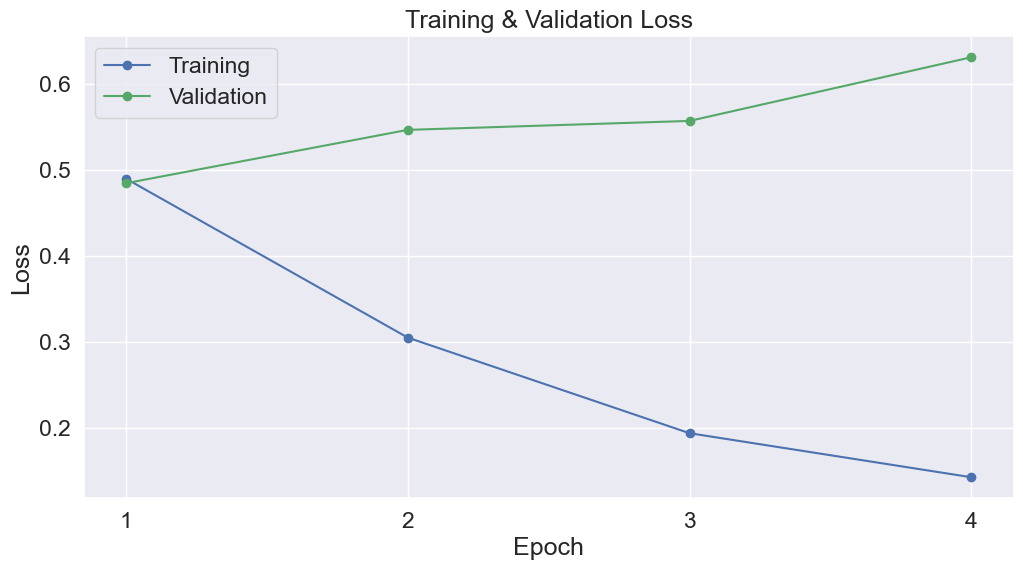

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# 5. Performance On Test Set

Теперь мы загрузим контрольный набор данных и подготовим входные данные так же, как мы это делали с обучающим набором. Затем мы оценим прогнозы, используя [Коэффициент корреляции Мэтьюза](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html) потому что это показатель, используемый более широким сообществом НЛП для оценки эффективности CoLA. При использовании этого показателя +1 — лучший результат, а -1 — худший. Таким образом, мы можем увидеть, насколько хорошо мы справляемся с современными моделями для этой конкретной задачи.

### 5.1. Data Preparation



Для подготовки набора тестовых данных нам нужно будет применить все те же шаги, что и для обучающих данных.

In [38]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df = pd.read_csv("./cola_public/raw/out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Create sentence and label lists
sentences = df.sentence.values
labels = df.label.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.
batch_size = 32

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 516



C:\Users\Руслан\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


## 5.2. Evaluate on Test Set



Подготовив тестовый набор, мы можем применить нашу точно настроенную модель для генерации прогнозов на тестовом наборе.

In [39]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch

  # Telling the model not to compute or store gradients, saving memory and
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids,
                     token_type_ids=None,
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 516 test sentences...
    DONE.


Точность теста CoLA измеряется с помощью "[Matthews correlation coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html)" (MCC).

Мы используем здесь MCC, потому что классы несбалансированы:


In [40]:
print('Positive samples: %d of %d (%.2f%%)' % (df.label.sum(), len(df.label), (df.label.sum() / len(df.label) * 100.0)))

Positive samples: 354 of 516 (68.60%)


In [41]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):

  # The predictions for this batch are a 2-column ndarray (one column for "0"
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()

  # Calculate and store the coef for this batch.
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


The final score will be based on the entire test set, but let's take a look at the scores on the individual batches to get a sense of the variability in the metric between batches.

Each batch has 32 sentences in it, except the last batch which has only (516 % 32) = 4 test sentences in it.


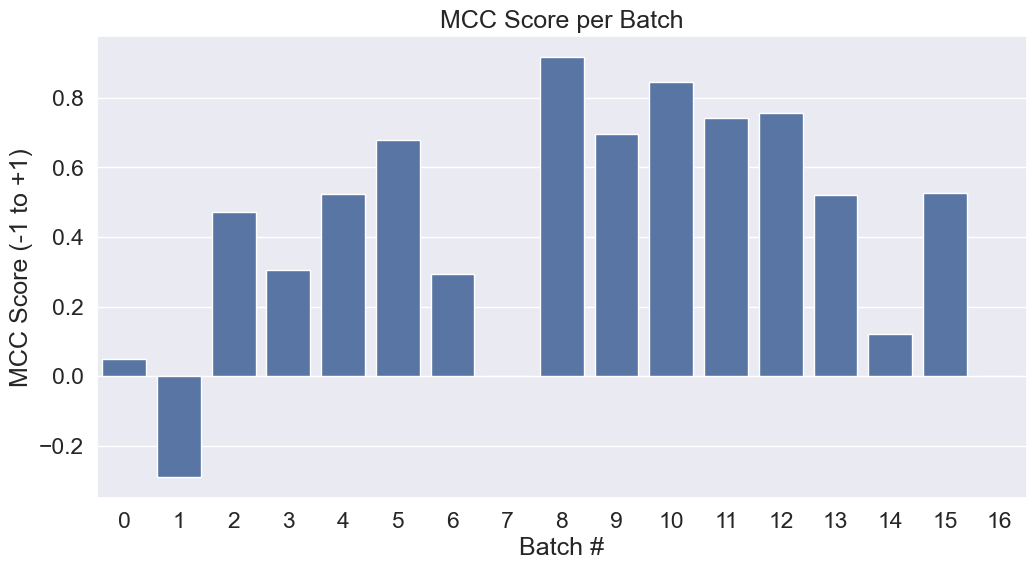

In [42]:
# Create a barplot showing the MCC score for each batch of test samples.
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, errorbar=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()

Now we'll combine the results for all of the batches and calculate our final MCC score.

In [43]:
# Combine the results across all batches.
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.498


Великолепно! Примерно за полчаса и без какой-либо настройки гиперпараметров (регулировки скорости обучения, эпох, размера пакета, свойств ADAM и т. д.) мы можем получить хороший результат.

> *Примечание: Чтобы максимизировать оценку, нам следует удалить «проверочный набор» (который мы использовали, чтобы определить, сколько эпох нужно обучать) и тренироваться на всем обучающем наборе.*

Библиотека документирует ожидаемую точность этого теста [here](https://huggingface.co/transformers/examples.html#glue) как `49.23`.

Вы также можете посмотреть официальную таблицу лидеров [here](https://gluebenchmark.com/leaderboard/submission/zlssuBTm5XRs0aSKbFYGVIVdvbj1/-LhijX9VVmvJcvzKymxy).

Обратите внимание, что (из-за небольшого размера набора данных?) точность может значительно различаться между запусками.


# Заключение

В этом посте показано, что с помощью предварительно обученной модели BERT вы можете быстро и эффективно создать высококачественную модель с минимальными усилиями и временем обучения, используя интерфейс pytorch, независимо от конкретной задачи НЛП, которая вас интересует.

# Appendix


## A1. Saving & Loading Fine-Tuned Model

This first cell (taken from `run_glue.py` [here](https://github.com/huggingface/transformers/blob/35ff345fc9df9e777b27903f11fa213e4052595b/examples/run_glue.py#L495)) writes the model and tokenizer out to disk.

In [ ]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.txt',
 './model_save/added_tokens.json')

Let's check out the file sizes, out of curiosity.

In [ ]:
!ls -l --block-size=K ./model_save/

total 428000K
-rw-r--r-- 1 root root      1K Feb  2 17:10 config.json
-rw-r--r-- 1 root root 427757K Feb  2 17:10 pytorch_model.bin
-rw-r--r-- 1 root root      1K Feb  2 17:10 special_tokens_map.json
-rw-r--r-- 1 root root      1K Feb  2 17:10 tokenizer_config.json
-rw-r--r-- 1 root root    227K Feb  2 17:10 vocab.txt


The largest file is the model weights, at around 418 megabytes.

In [ ]:
!ls -l --block-size=M ./model_save/pytorch_model.bin

-rw-r--r-- 1 root root 418M Feb  2 17:10 ./model_save/pytorch_model.bin


To save your model across Colab Notebook sessions, download it to your local machine, or ideally copy it to your Google Drive.

In [ ]:
# Mount Google Drive to this Notebook instance.
from google.colab import drive
    drive.mount('/content/drive')

In [ ]:
# Copy the model files to a directory in your Google Drive.
!cp -r ./model_save/ "./drive/Shared drives/ChrisMcCormick.AI/Blog Posts/BERT Fine-Tuning/"

The following functions will load the model back from disk.

In [ ]:
# Load a trained model and vocabulary that you have fine-tuned
model = model_class.from_pretrained(output_dir)
tokenizer = tokenizer_class.from_pretrained(output_dir)

# Copy the model to the GPU.
model.to(device)

## A.2. Weight Decay



The huggingface example includes the following code block for enabling weight decay, but the default decay rate is "0.0", so I moved this to the appendix.

This block essentially tells the optimizer to not apply weight decay to the bias terms (e.g., $ b $ in the equation $ y = Wx + b $ ). Weight decay is a form of regularization--after calculating the gradients, we multiply them by, e.g., 0.99.

In [ ]:
# This code is taken from:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L102

# Don't apply weight decay to any parameters whose names include these tokens.
# (Here, the BERT doesn't have `gamma` or `beta` parameters, only `bias` terms)
no_decay = ['bias', 'LayerNorm.weight']

# Separate the `weight` parameters from the `bias` parameters.
# - For the `weight` parameters, this specifies a 'weight_decay_rate' of 0.01.
# - For the `bias` parameters, the 'weight_decay_rate' is 0.0.
optimizer_grouped_parameters = [
    # Filter for all parameters which *don't* include 'bias', 'gamma', 'beta'.
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.1},

    # Filter for parameters which *do* include those.
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

# Note - `optimizer_grouped_parameters` only includes the parameter values, not
# the names.

# Revision History

**Version 4** - *Feb 2nd, 2020* - (current)
* Updated all calls to `model` (fine-tuning and evaluation) to use the [`SequenceClassifierOutput`](https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput) class.
* Moved illustration images to Google Drive--Colab appears to no longer support images at external URLs.

**Version 3** - *Mar 18th, 2020*
* Simplified the tokenization and input formatting (for both training and test) by leveraging the `tokenizer.encode_plus` function.
`encode_plus` handles padding *and* creates the attention masks for us.
* Improved explanation of attention masks.
* Switched to using `torch.utils.data.random_split` for creating the training-validation split.
* Added a summary table of the training statistics (validation loss, time per epoch, etc.).
* Added validation loss to the learning curve plot, so we can see if we're overfitting.
    * Thank you to [Stas Bekman](https://ca.linkedin.com/in/stasbekman) for contributing this!
* Displayed the per-batch MCC as a bar plot.

**Version 2** - *Dec 20th, 2019* - [link](https://colab.research.google.com/drive/1Y4o3jh3ZH70tl6mCd76vz_IxX23biCPP)
* huggingface renamed their library to `transformers`.
* Updated the notebook to use the `transformers` library.

**Version 1** - *July 22nd, 2019*
* Initial version.

## Further Work

* It might make more sense to use the MCC score for “validation accuracy”, but I’ve left it out so as not to have to explain it earlier in the Notebook.
* Seeding -- I’m not convinced that setting the seed values at the beginning of the training loop is actually creating reproducible results…
* The MCC score seems to vary substantially across different runs. It would be interesting to run this example a number of times and show the variance.
